In [1]:
import numpy as np
import scipy as sp
import torch
import pickle
import os
import json
import glob
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
import logging

In [2]:
MODELS = ['mini_GPT', 'OPT', 'pythia']
MODEL_NAMES = ['GPT-4o mini', 'OPT-2.7B', 'Pythia-2.8B']
FIG_OUT = "figures"
os.makedirs(FIG_OUT, exist_ok=True)

PYTHIA = "EleutherAI/pythia-2.8b"
OPT = "facebook/opt-2.7b"

tokenizer = AutoTokenizer.from_pretrained(PYTHIA)
tokenizer.pad_token = tokenizer.eos_token

C:\Users\shiri\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
models=MODELS
willvoigt = os.path.join(models[0], "Will Voigt_data.pkl")
arronburr = os.path.join(models[0], "Aaron Burr_data.pkl")
dalai = os.path.join(models[2], "14th Dalai Lama_data.pkl")
willangel = os.path.join(models[0], "William G. Angel_data.pkl")

with open(willvoigt, "rb") as f:
    dat0 = pickle.load(f)

with open(arronburr, "rb") as f:
    dat1 = pickle.load(f)

with open(dalai, "rb") as f:
    dat2 = pickle.load(f)

# Pathological example
with open(willangel, "rb") as f:
    dat3 = pickle.load(f)

#for path in glob.glob(globpath):
#    with open(path, "rb") as f:
#        dat = pickle.load(f)
#    break

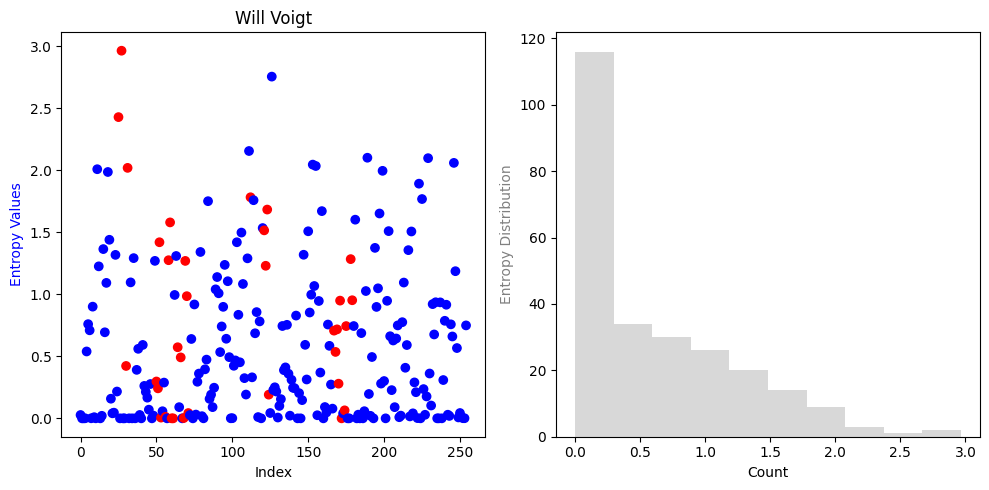

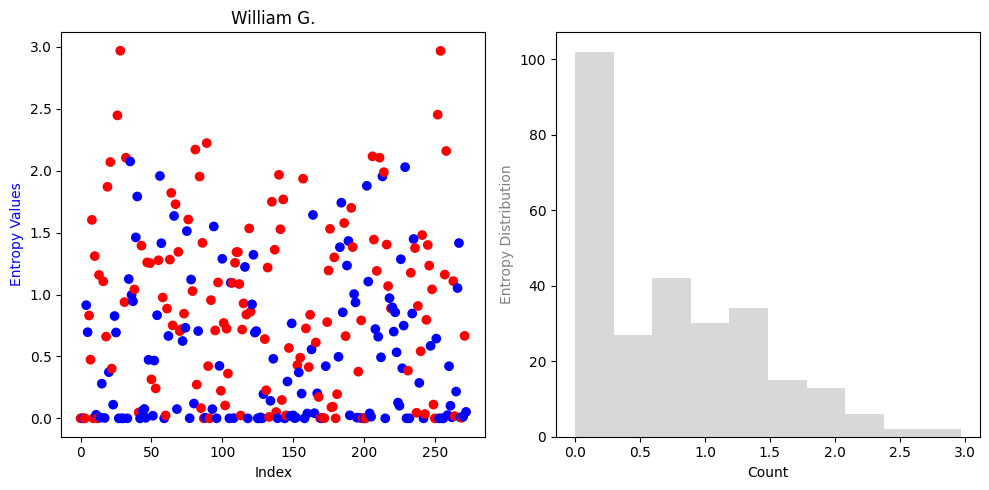

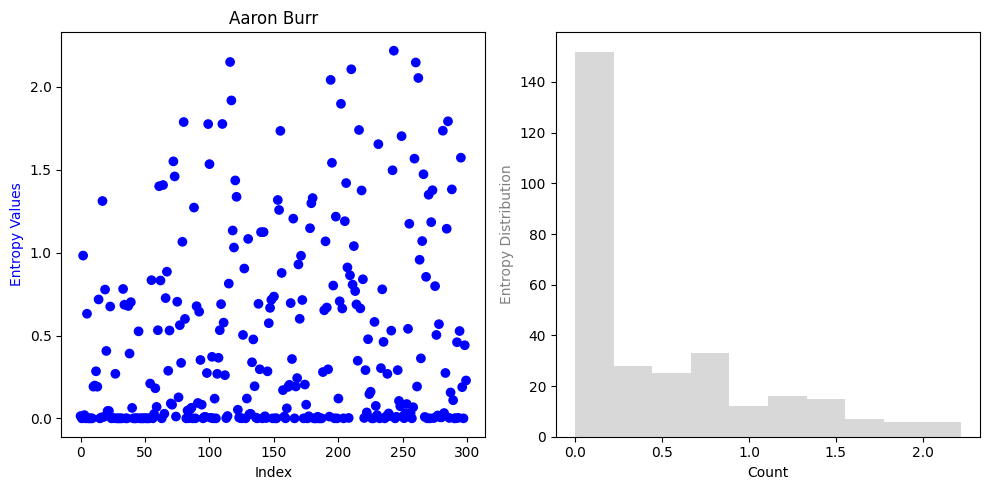

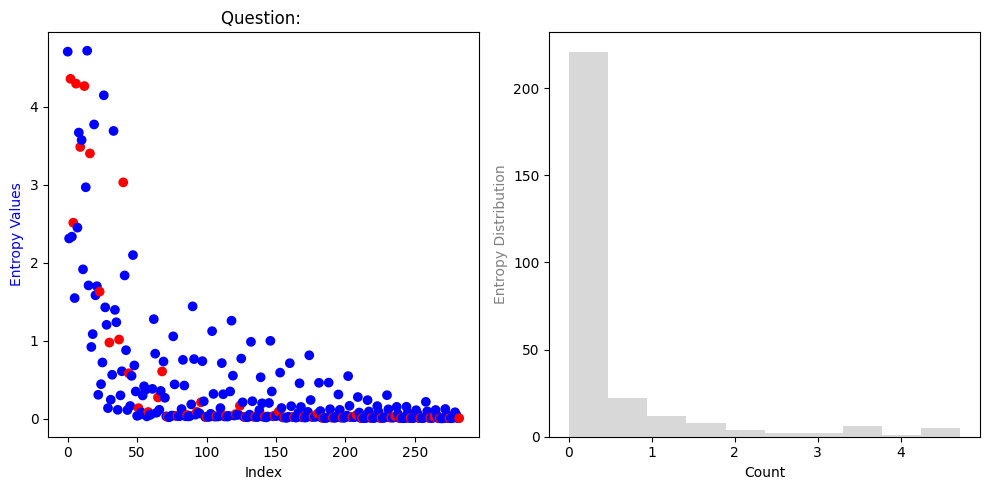

In [4]:
for dat in [dat0, dat3, dat1,dat2]: #
    rel_labels = dat['labels'][-dat['top_k_probs'].shape[0]:]
    rel_probs = dat['top_k_probs']
    ents = sp.stats.entropy(rel_probs, axis = 1)
    colors = ['blue' if i == 0 else 'red' for i in rel_labels]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Scatter plot on the left
    ax1.scatter(np.arange(len(ents)), ents, c=colors)
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Entropy Values", color="blue")
    ax1.set_title(f"{dat['generation'][:10]}")

    # Histogram on the right
    ax2.hist(ents, bins=10, orientation='vertical', alpha=0.3, color='gray')
    ax2.set_xlabel("Count")
    ax2.set_ylabel("Entropy Distribution", color="gray")
    
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()
    
    # Scatter plot of A and B values
    #plt.scatter(np.arange(len(ents)), ents, c=colors)
    # Add labels and legend
    #plt.title(f"{dat['generation'][:10]}")
    #plt.xlabel("Index")
    #plt.ylabel("Values")
    #plt.show()

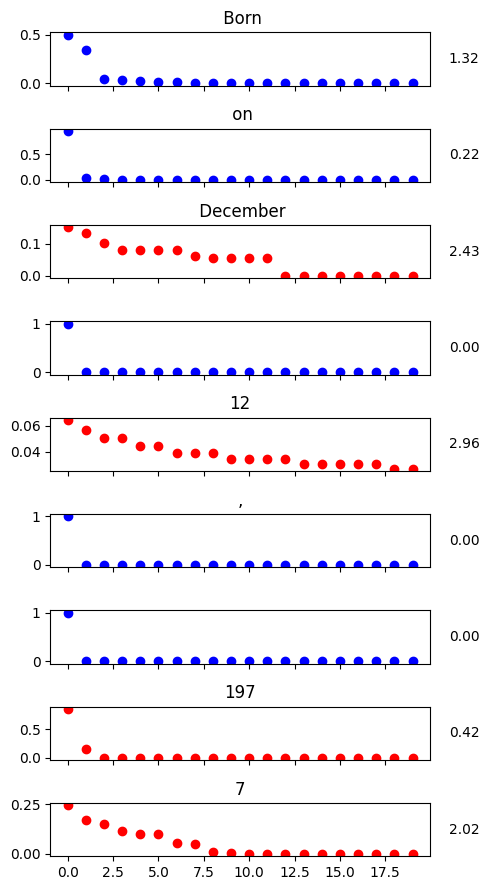

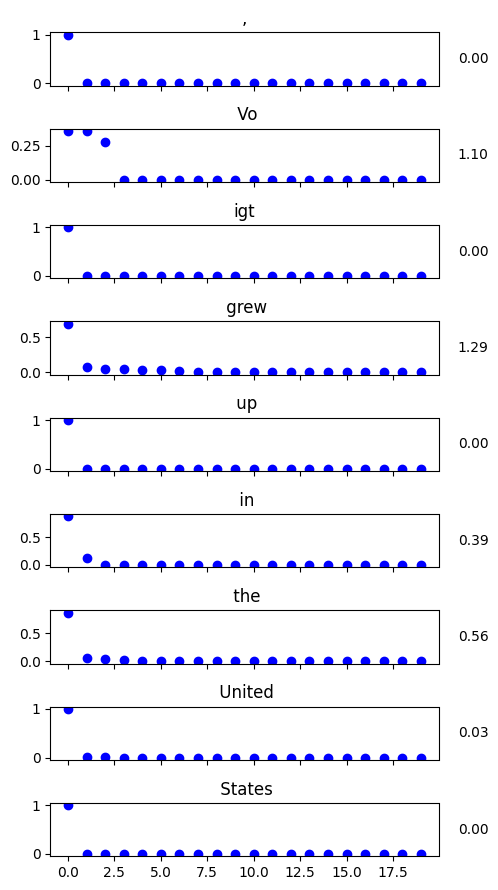

In [76]:
def draw_lie_plot(data, start_idx, n_plots, name=""):
    fig, axes = plt.subplots(n_plots, 1, figsize=(5, n_plots), sharex=True)
    ents = sp.stats.entropy(data['top_k_probs'], axis = 1)
    for i, vec in enumerate(data['top_k_probs'][start_idx:start_idx+n_plots]):
        vec = vec.tolist()[::-1]
        col = 'red' if data['labels'][start_idx + i] == 1 else 'blue'
        axes[i].scatter(np.arange(len(vec)), vec, c=col)
        axes[i].set_title(data['tokens'][start_idx + i])
        
    
        axes[i].annotate(f"{ents[i+start_idx]:.2f}", xy=(1.05, 0.5), xycoords='axes fraction', 
                         fontsize=10, ha='left', va='center')
    plt.tight_layout()
    if name:
        plt.savefig(name, format="pdf", bbox_inches="tight")
    plt.show()

draw_lie_plot(dat0, 23, 9, os.path.join(FIG_OUT, "cool_entropy_example1.pdf"))
draw_lie_plot(dat0, 32, 9, os.path.join(FIG_OUT, "cool_entropy_example2.pdf"))


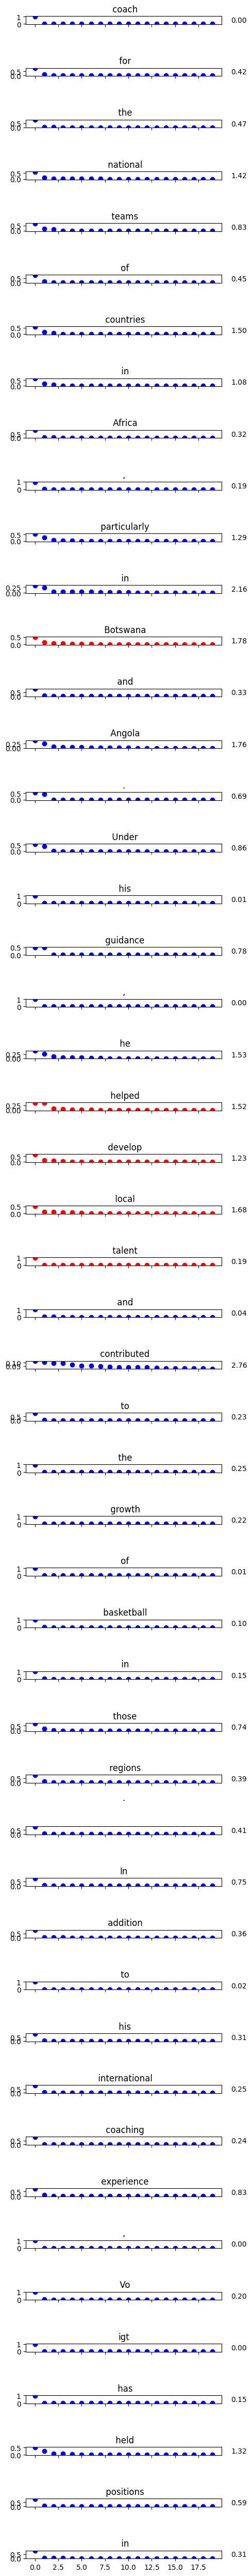

In [6]:
draw_lie_plot(dat0, 100, 50)

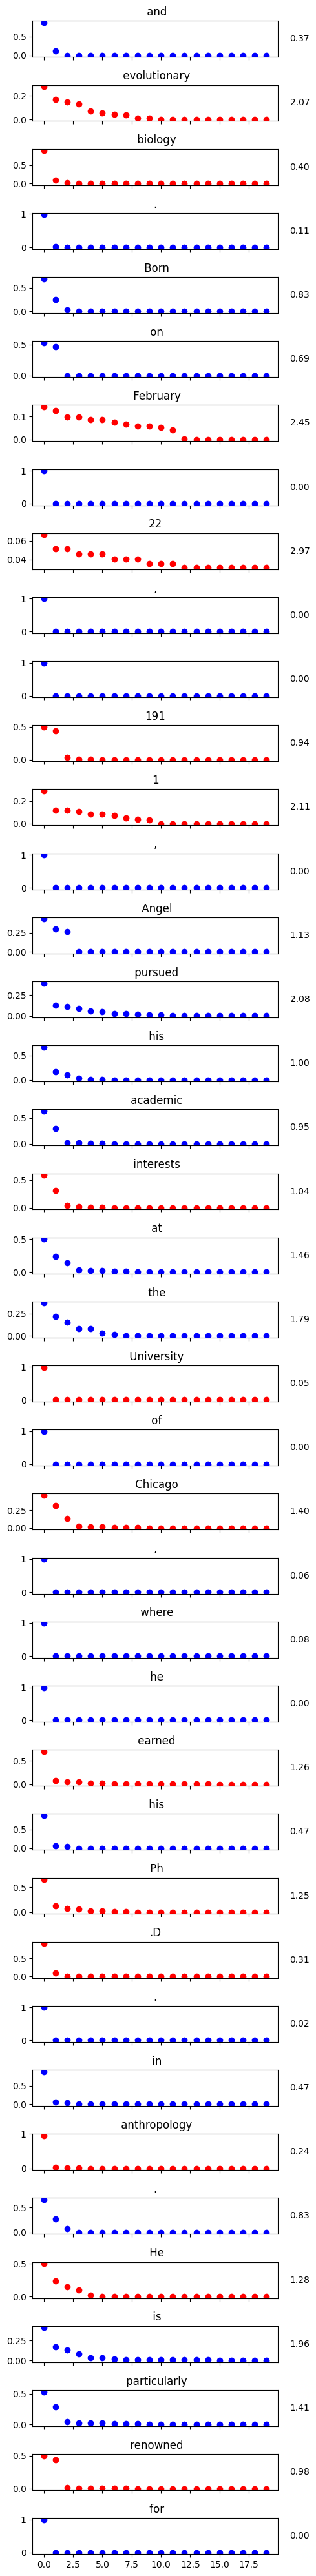

In [7]:
draw_lie_plot(dat3, 20, 40)

In [3]:
# Entropy of all gens

Pearson correlation: 0.34, p-value: 0.0000


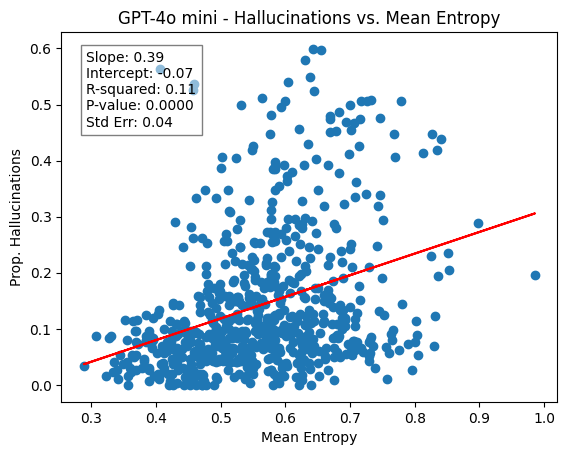

Pearson correlation: -0.03, p-value: 0.6341


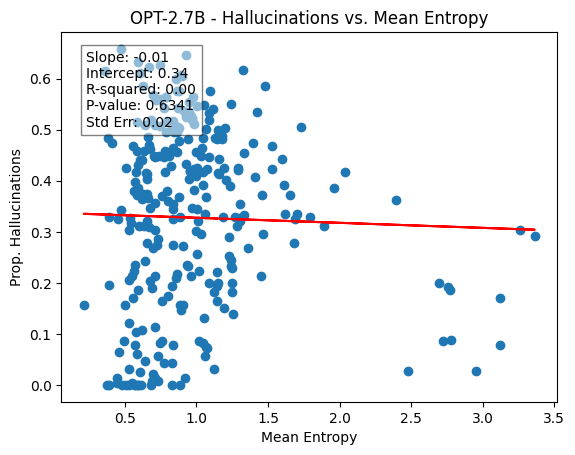

Pearson correlation: 0.24, p-value: 0.0000


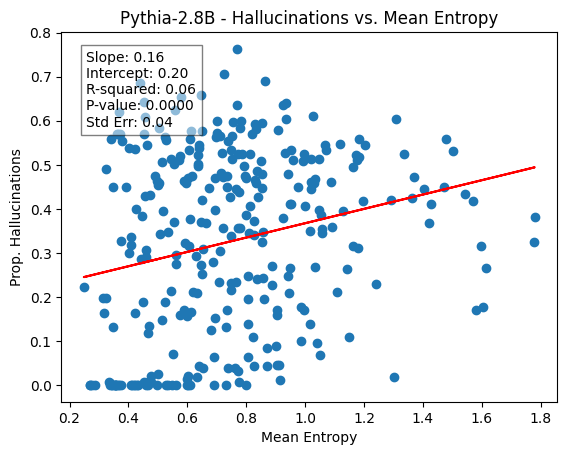

In [62]:
import scipy.stats as stats

def draw_scatter(all_probs, all_labels, title="Scatter Plot with Regression Line and Statistics"):
    prop_lies = []
    avg_ent = []

    for probs, labels in zip(all_probs, all_labels):
        prop_lies.append(sum(labels)/len(labels))
        avg_ent.append(np.mean(sp.stats.entropy(probs, axis = 1)))
        #avg_max_prob.append(np.mean(np.max(probs.tolist(), axis=1)))
        #avg_fourth_prob.append(np.mean([i[-4].tolist()/i[-1] for i in dat['top_k_probs']]))
    
    y = np.array(prop_lies)
    x = np.array(avg_ent)
    pearson_corr, pearson_pval = stats.pearsonr(x, y)

    # Display the result
    print(f"Pearson correlation: {pearson_corr:.2f}, p-value: {pearson_pval:.4f}")
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Create scatter plot
    plt.scatter(x, y, label='Data')
    
    # Plot the regression line
    plt.plot(x, slope * x + intercept, color='red', label='Regression Line')
    
    # Display regression statistics
    plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.2f}\nP-value: {p_value:.4f}\nStd Err: {std_err:.2f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add labels and legend
    plt.xlabel('Mean Entropy')
    plt.ylabel('Prop. Hallucinations')
    plt.title(title)
    plt.savefig(os.path.join(FIG_OUT, f"{title}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

for i, model in enumerate(MODELS):
    all_probs = []
    all_labels = []
    for path in glob.glob(os.path.join(model, "*.pkl")):
        with open(path, "rb") as f:
            dat = pickle.load(f)
        all_probs.append(dat['top_k_probs'])
        all_labels.append(dat['labels'][-dat['top_k_probs'].shape[0]:])
    
    draw_scatter(all_probs, all_labels, f"{MODEL_NAMES[i]} - Hallucinations vs. Mean Entropy")

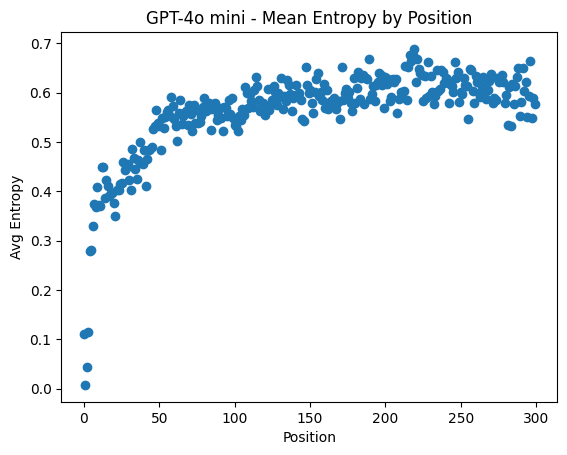

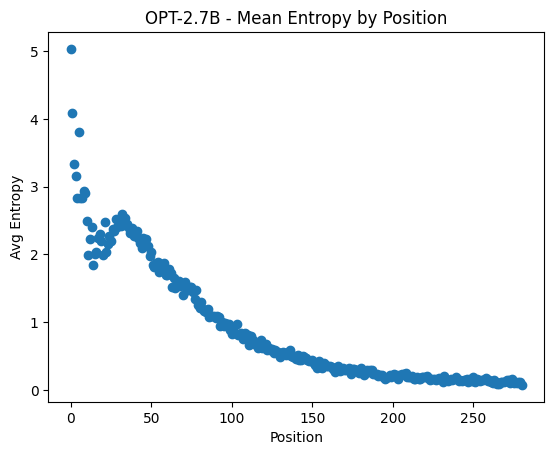

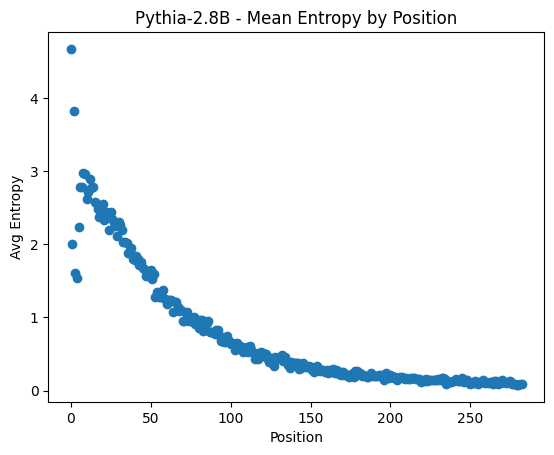

In [63]:
def avg_array(arrays):
    max_len = max(len(arr) for arr in arrays)
    sum_array = np.zeros(max_len)
    count_array = np.zeros(max_len)
    for arr in arrays:
        sum_array[:len(arr)] += arr
        count_array[:len(arr)] += 1
    return sum_array / count_array

def draw_ent_by_position_scatter(all_probs, title="Scatter Plot with Regression Line and Statistics"):
    prop_lies = []
    avg_ents = []

    for probs in all_probs:
        avg_ents.append(sp.stats.entropy(probs, axis = 1))

    y = avg_array(avg_ents)
    x = np.arange(max(len(arr) for arr in avg_ents))

    # Create scatter plot
    plt.scatter(x, y, label='Data')
    
    # Add labels and legend
    plt.xlabel('Position')
    plt.ylabel('Avg Entropy')
    plt.title(title)
    plt.savefig(os.path.join(FIG_OUT, f"{title}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

for i, model in enumerate(MODELS):
    all_probs = []
    for path in glob.glob(os.path.join(model, "*.pkl")):
        with open(path, "rb") as f:
            dat = pickle.load(f)
        all_probs.append(dat['top_k_probs'])
    
    draw_ent_by_position_scatter(all_probs, f"{MODEL_NAMES[i]} - Mean Entropy by Position")

In [3]:
def create_windows(entry_data, window_size, stride, top_k=20, logit_key_name="top_k_probs", label_key_name="labels"):
    logits = entry_data[logit_key_name][:, -top_k:]
    # Cut labels to remove prompt
    labels = entry_data[label_key_name][-logits.shape[0]:]

    num_windows = ((logits.shape[0] - window_size) // stride) + 1

    # Create windows for the logits based on window size and stride
    logits_windows = np.lib.stride_tricks.sliding_window_view(logits, (window_size, logits.shape[1]))[::stride]
    logits_windows = logits_windows.squeeze(1)

    # Create windows for the labels based on window size and stride
    labels_windows = np.lib.stride_tricks.sliding_window_view(labels, window_size)[::stride]

    assert (num_windows == logits_windows.shape[0])
    assert (num_windows == labels_windows.shape[0])

    return logits_windows, labels_windows


In [11]:
def do_ent(dat):
    return sp.stats.entropy(dat['top_k_probs'], axis = 1)

def do_max_prob(dat):
    return np.max(dat['top_k_probs'].tolist(), axis = 1)

def do_4th_prob(dat):
    return np.array([i[-4].tolist()/i[-1] for i in dat['top_k_probs']])

def do_max_diff(dat):
    diffed = np.abs(np.diff(dat['top_k_probs'].tolist(), axis = 1))
    return np.max(diffed, axis = 1)



In [6]:
def draw_double_histogram(in_logits, in_labels, title="title", logscale=False, xlabel="Entropy"):
    all_ents_hall = np.array(in_logits)[np.array(in_labels)==1]
    all_ents_true = np.array(in_logits)[np.array(in_labels)==0]
    
    plt.hist(all_ents_hall, bins=50, alpha=0.5, label='Hallucination', color='blue', weights = np.ones_like(all_ents_hall) / len(all_ents_hall))
    plt.hist(all_ents_true, bins=50, alpha=0.5, label='Truth', color='orange', weights =  np.ones_like(all_ents_true) / len(all_ents_true))
    
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    if logscale:
        plt.yscale('log')
        
    plt.legend()
    plt.title(title)
    plt.savefig(os.path.join(FIG_OUT, f"{title}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

In [32]:
# Single token Statistics

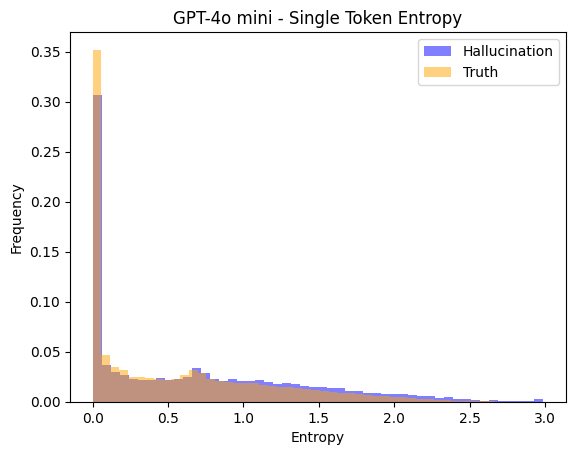

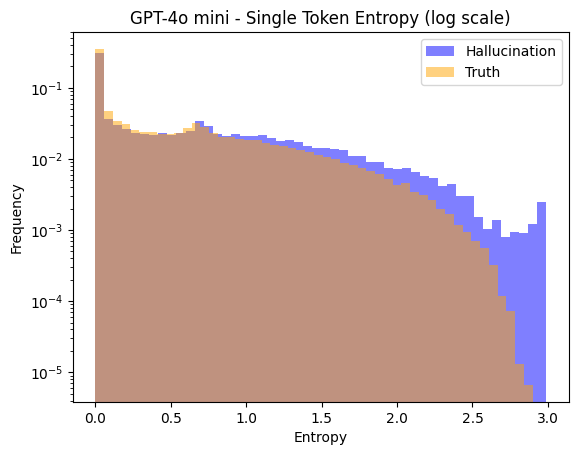

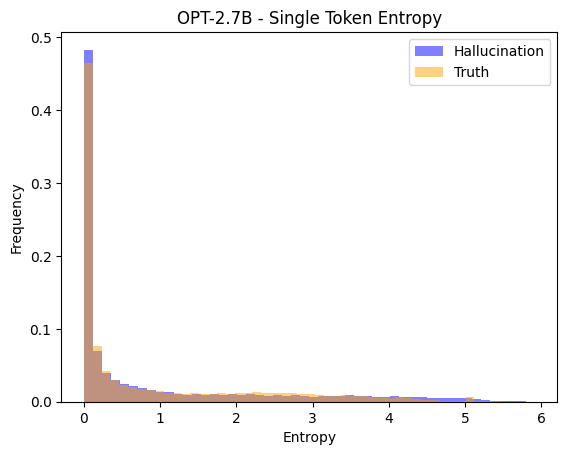

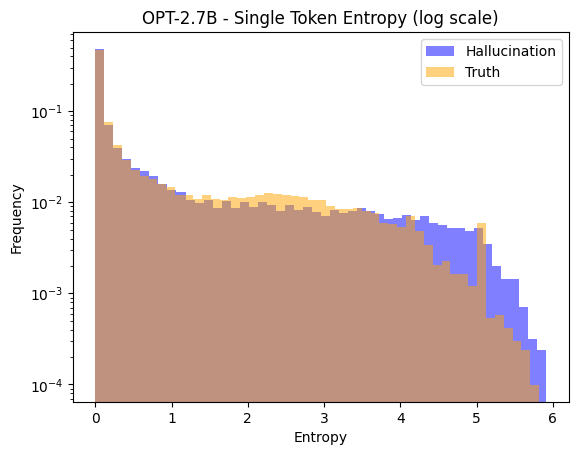

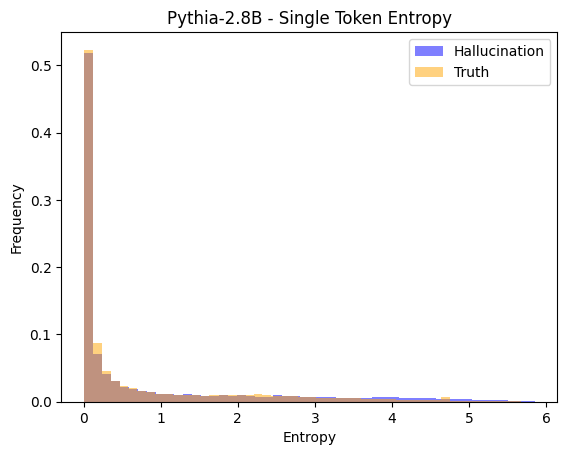

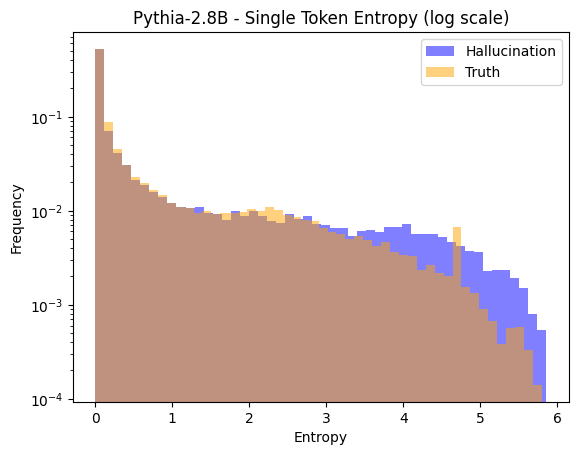

In [71]:
for i, model in enumerate(MODELS):
    all_ents = []
    all_labels = []
    for path in glob.glob(os.path.join(model, "*.pkl")):
        with open(path, "rb") as f:
            dat = pickle.load(f)
        ents = do_ent(dat)
        all_ents.extend(ents)
        all_labels.extend(dat['labels'][-ents.shape[0]:])  
    
    draw_double_histogram(all_ents, all_labels, f"{MODEL_NAMES[i]} - Single Token Entropy")
    draw_double_histogram(all_ents, all_labels, f"{MODEL_NAMES[i]} - Single Token Entropy (log scale)", True)

In [31]:
# Windowed Statistics

In [69]:
def do_std_bigdiff(logits):
    return np.std(np.max(logits,axis=0) - np.min(logits,axis=0))

def do_avg_bigdiff(logits):
    return np.mean(np.max(logits,axis=0) - np.min(logits,axis=0))

def do_max_bigdiff(logits):
    return np.max(np.max(logits,axis=0) - np.min(logits,axis=0))

def do_ent_bigdiff(logits):
    return sp.stats.entropy(np.max(logits,axis=0) - np.min(logits,axis=0))


Doing mini_GPT:5:5


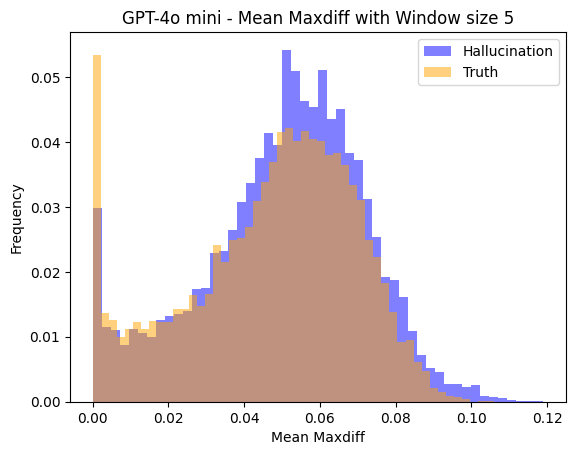

Doing mini_GPT:10:10


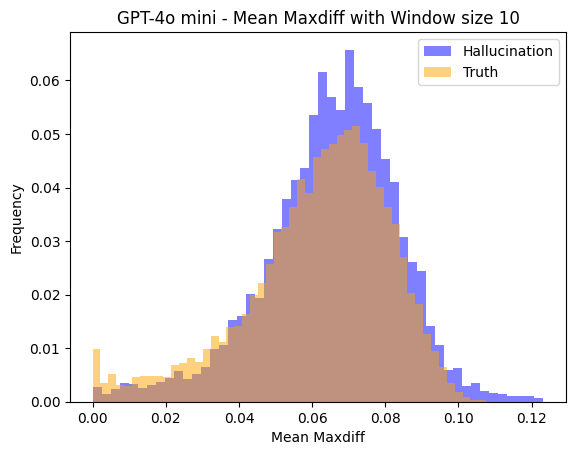

Doing mini_GPT:50:50


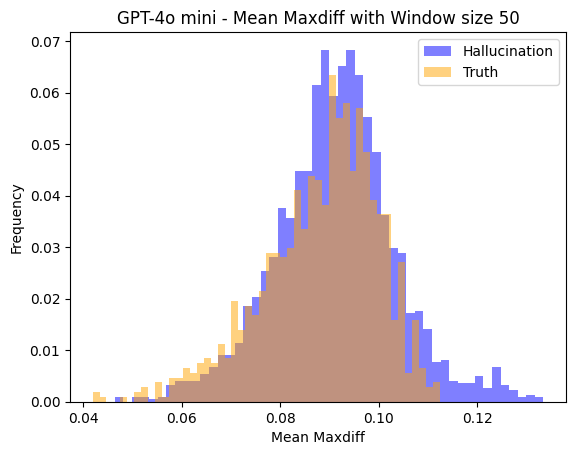

Doing OPT:5:5


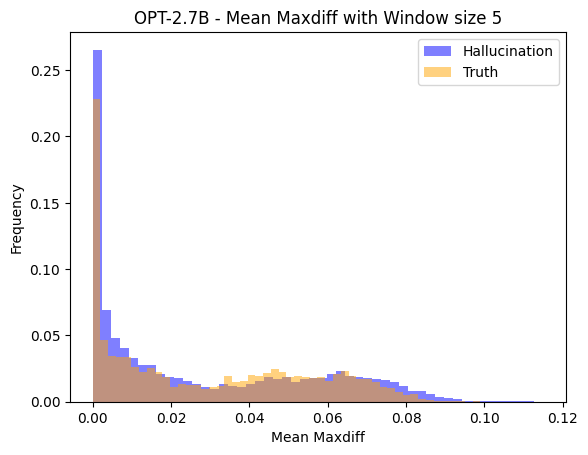

Doing OPT:10:10


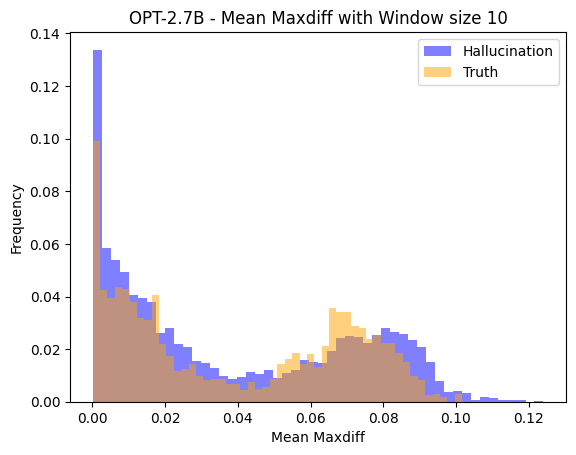

Doing OPT:50:50
Skipping OPT\Radja Nainggolan_data.pkl
Skipping OPT\Rii Sen_data.pkl
Skipping OPT\Stephen Miller (political advisor)_data.pkl


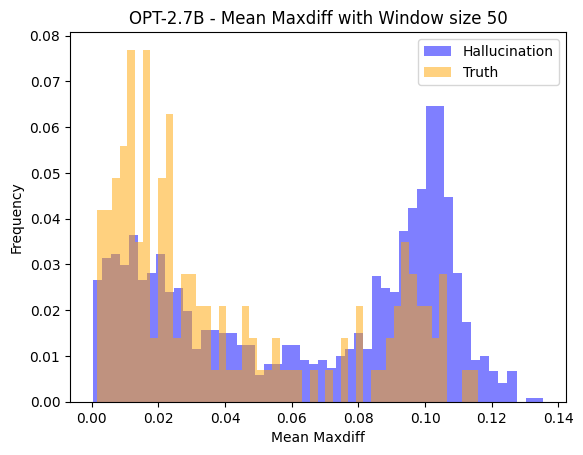

Doing pythia:5:5


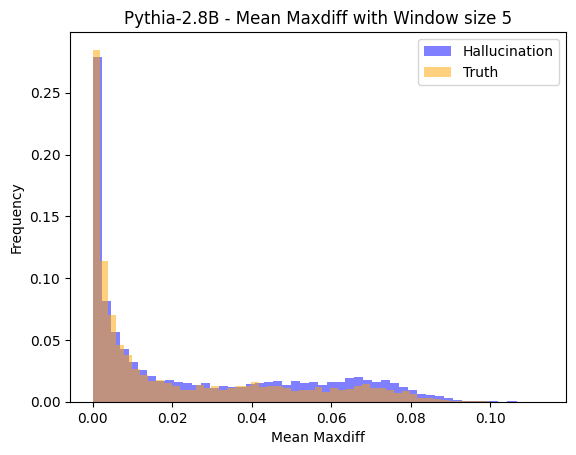

Doing pythia:10:10


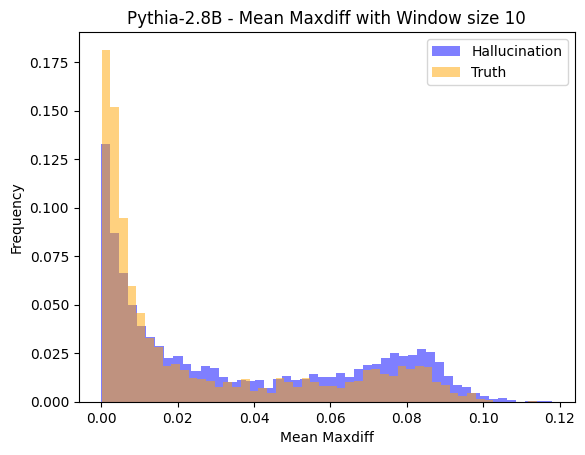

Doing pythia:50:50


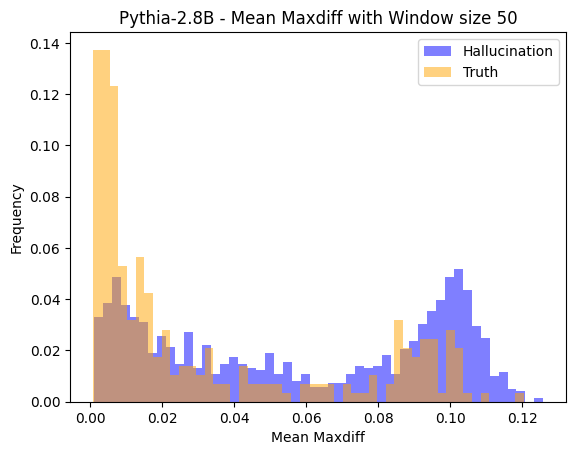

In [75]:
for i, model in enumerate(MODELS):
    for winsize in [5, 10, 50]:
        for stride in [winsize]:
            print(f"Doing {model}:{winsize}:{stride}")
            all_logits = []
            all_labels = []
            for path in glob.glob(os.path.join(model, "*.pkl")):
                with open(path, "rb") as f:
                    dat = pickle.load(f)
                try:
                    logits_windows, labels_windows = create_windows(dat, winsize, stride)
                    for logits, labels in zip(logits_windows, labels_windows):
                        all_logits.append(do_avg_bigdiff(logits))
                        all_labels.append(1 if 1 in labels else 0)
                except:
                    print(f"Skipping {path}")
    
        draw_double_histogram(all_logits, all_labels,  f"{MODEL_NAMES[i]} - Mean Maxdiff with Window size {winsize}", xlabel="Mean Maxdiff")              

In [19]:
# Metrics from "A Stitch in Time Saves Nine"
# With concept words

In [4]:
paper_comp_data_loc = os.path.join("..", "data_for_paper_comparison", "openai_chosen_token_and_concepts")
paper_comp_data_loc2 = os.path.join("..", "data_for_paper_comparison", "openai_chosen_token_and_concepts_new")
os.makedirs(paper_comp_data_loc2, exist_ok=True)

In [41]:
for path in glob.glob(os.path.join('mini_GPT', "*.pkl")):
    with open(path, "rb") as f:
        dat = pickle.load(f)
    entity = os.path.basename(path).replace("_data.pkl", "")
    FNAME = "{0}_gpt-4o-mini-2024-07-18_300_w_chosen_token_and_concepts.pkl"
    with open(os.path.join(paper_comp_data_loc, FNAME.format(entity)), "rb") as f:
        dat2 = pickle.load(f)
    
    new_keys = ['chosen_token_logit', 'chosen_token_prob', 'concept_words', 'entity']
    for nkey in new_keys:
        dat[nkey] = dat2[nkey]
    
    with open(os.path.join(paper_comp_data_loc2, FNAME.format(entity)), "wb") as f:
        pickle.dump(dat, f)

mini_GPT\14th Dalai Lama_data.pkl
mini_GPT\A. K. Ramanujan_data.pkl
mini_GPT\Aaron Burr_data.pkl
mini_GPT\Abdelhamid Shabana_data.pkl
mini_GPT\Abdou Diallo_data.pkl
mini_GPT\Abdul Halik Hudu_data.pkl
mini_GPT\Abdul Ilah Khatib_data.pkl
mini_GPT\Abdullahi Mohammad Ahmad Hassan_data.pkl
mini_GPT\Abdulqawi Yusuf_data.pkl
mini_GPT\Abraham Ancer_data.pkl
mini_GPT\Adel Emam_data.pkl
mini_GPT\Adil Rami_data.pkl
mini_GPT\Aditya Kalyanpur_data.pkl
mini_GPT\Adnan Sami_data.pkl
mini_GPT\Aert van der Neer_data.pkl
mini_GPT\Ahmed Mumin Warfa_data.pkl
mini_GPT\Ahn Jae-hyun_data.pkl
mini_GPT\Ahsee Tuala_data.pkl
mini_GPT\Akbar Hossain_data.pkl
mini_GPT\Albert Outler_data.pkl
mini_GPT\Alberto Malesani_data.pkl
mini_GPT\Aleksandar Kolarov_data.pkl
mini_GPT\Alen Omić_data.pkl
mini_GPT\Alexander Vovin_data.pkl
mini_GPT\Alexandre Guilmant_data.pkl
mini_GPT\Alexandre Hohagen_data.pkl
mini_GPT\Alf Garland_data.pkl
mini_GPT\Alfred Hitchcock_data.pkl
mini_GPT\Alice Torriani_data.pkl
mini_GPT\Alma Katsu_data.p

Doing 5:5


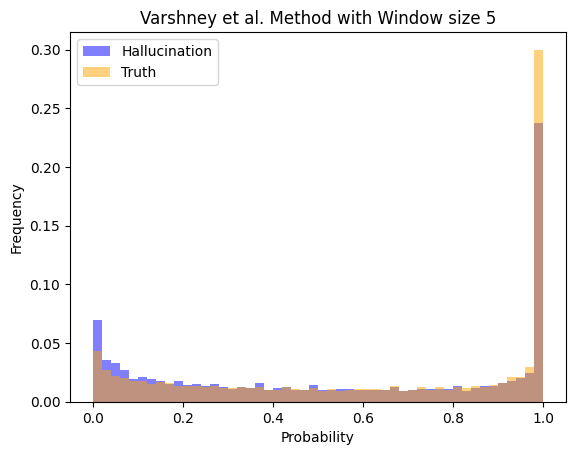

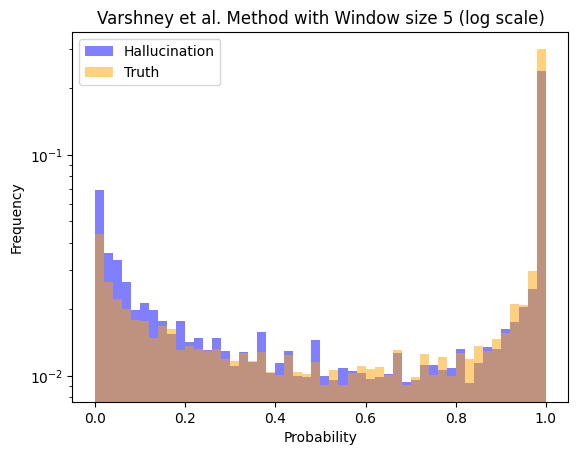

Doing 10:10


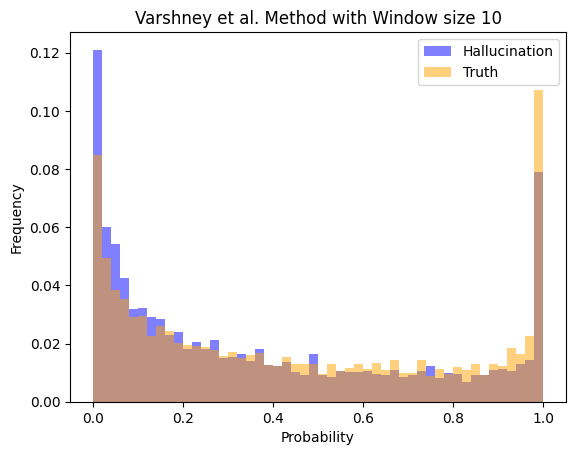

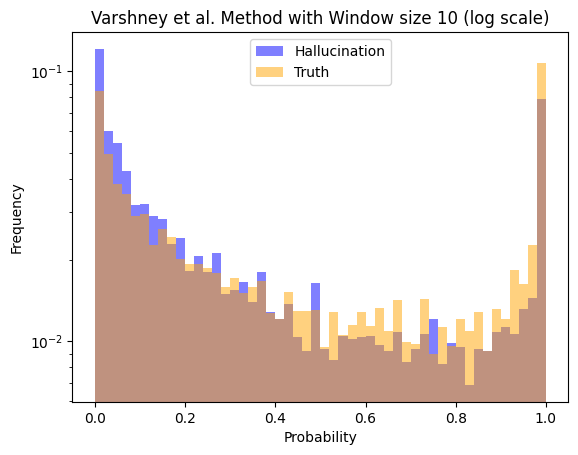

Doing 50:50


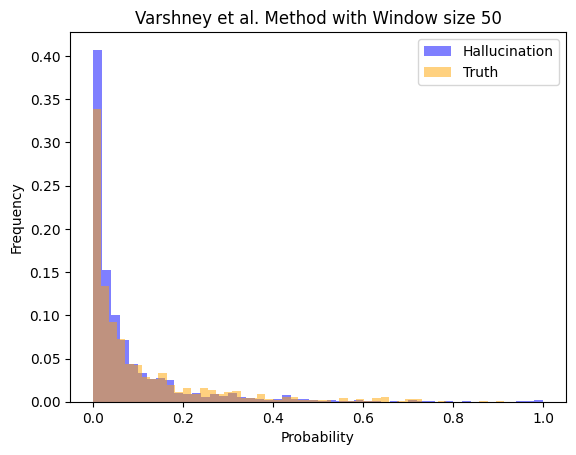

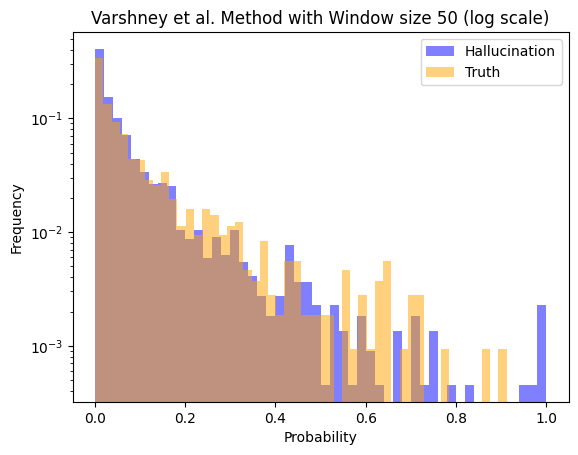

In [7]:
def do_thing(probs, concepts):
    relevant_probs = probs[concepts == 1]
    if len(relevant_probs) == 0:
        return 1
    return np.min(relevant_probs)

for winsize in [5, 10, 50]:
    for stride in [winsize]:
        print(f"Doing {winsize}:{stride}")
        all_probs = []
        all_labels = []
        for path in glob.glob(os.path.join(paper_comp_data_loc, "*.pkl")):
            with open(path, "rb") as f:
                dat = pickle.load(f)
            try:
                logits_windows, labels_windows = create_windows(dat, winsize, stride)
                dat['chosen_token_prob2'] = dat['chosen_token_prob'].unsqueeze(1)
                prob_windows, concept_windows = create_windows(dat, winsize, stride, logit_key_name="chosen_token_prob2", label_key_name='concept_words')
                prob_windows = prob_windows.squeeze(2)

                for probs, labels, concepts in zip(prob_windows, labels_windows, concept_windows):
                    all_probs.append(do_thing(probs, concepts))
                    all_labels.append(1 if 1 in labels else 0)
            except Exception as e:
                print(f"Skipping {path}: {e}")

    draw_double_histogram(all_probs, all_labels,  f"Varshney et al. Method with Window size {winsize}", xlabel="Probability") 
    draw_double_histogram(all_probs, all_labels,  f"Varshney et al. Method with Window size {winsize} (log scale)", True, xlabel="Probability") 

Doing 5:5


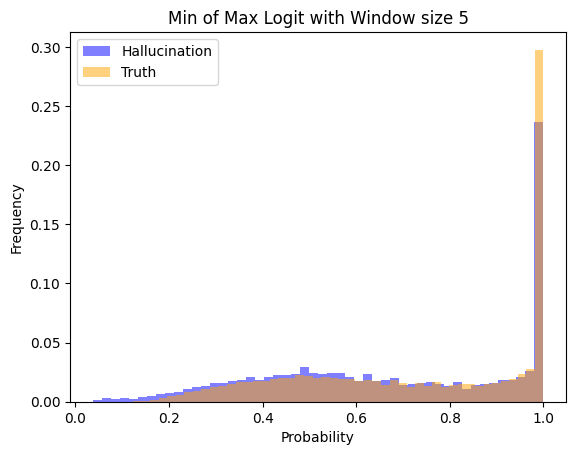

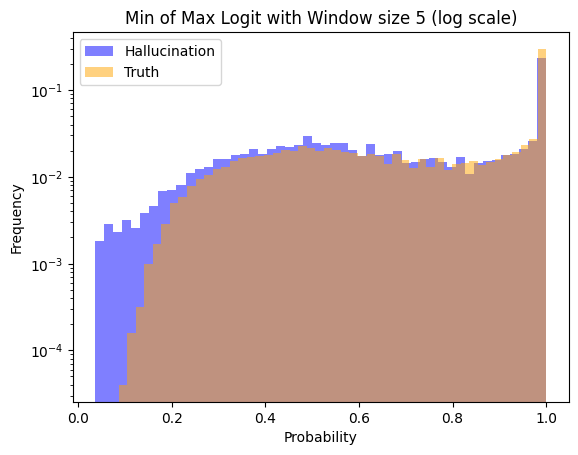

Doing 10:10


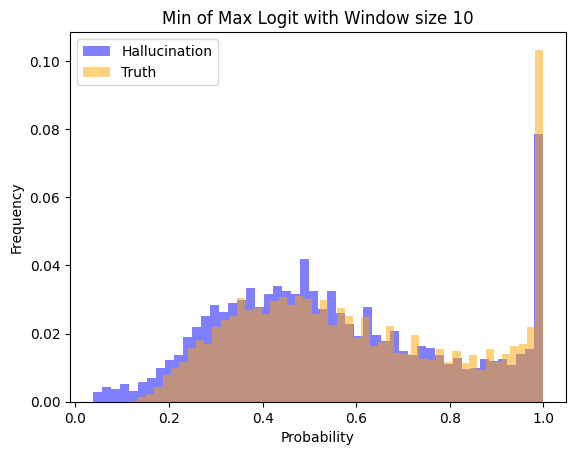

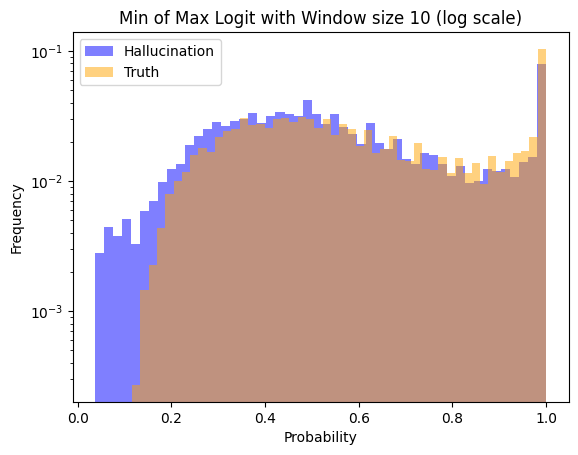

Doing 50:50


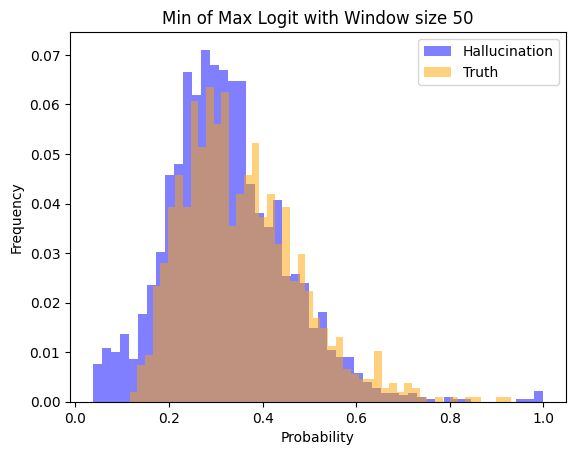

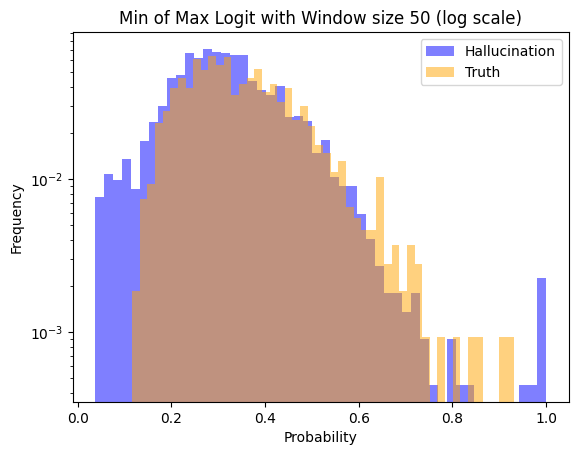

In [9]:
def do_min_of_max(probs, concepts):
    relevant_probs = probs[concepts == 1]
    if len(relevant_probs) == 0:
        return 1
    return np.min(np.max(relevant_probs, axis=1))

for winsize in [5, 10, 50]:
    for stride in [winsize]:
        print(f"Doing {winsize}:{stride}")
        all_probs = []
        all_labels = []
        for path in glob.glob(os.path.join(paper_comp_data_loc, "*.pkl")):
            with open(path, "rb") as f:
                dat = pickle.load(f)
            try:
                logits_windows, labels_windows = create_windows(dat, winsize, stride)
                dat['chosen_token_prob2'] = dat['chosen_token_prob'].unsqueeze(1)
                prob_windows, concept_windows = create_windows(dat, winsize, stride, logit_key_name="chosen_token_prob2", label_key_name='concept_words')
                prob_windows = prob_windows.squeeze(2)
                for logits, labels, concepts in zip(logits_windows, labels_windows, concept_windows):
                    all_probs.append(do_min_of_max(logits, concepts))
                    all_labels.append(1 if 1 in labels else 0)
            except Exception as e:
                print(f"Skipping {path}: {e}")

    draw_double_histogram(all_probs, all_labels,  f"Min of Max Logit with Window size {winsize}", xlabel="Probability") 
    draw_double_histogram(all_probs, all_labels,  f"Min of Max Logit with Window size {winsize} (log scale)", True, xlabel="Probability") 

In [26]:
# Are there more hallucinations as the text length increases?

Doing mini_GPT


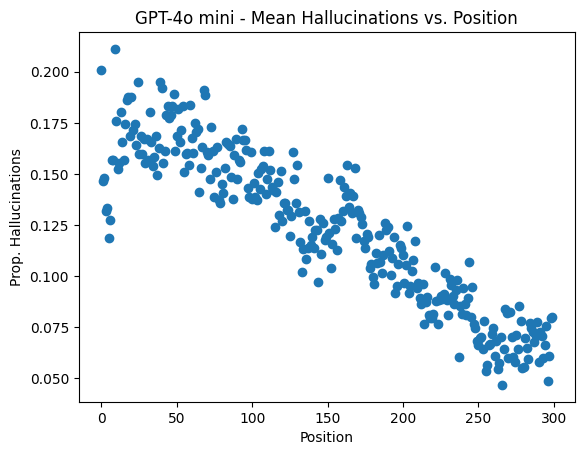

Doing OPT


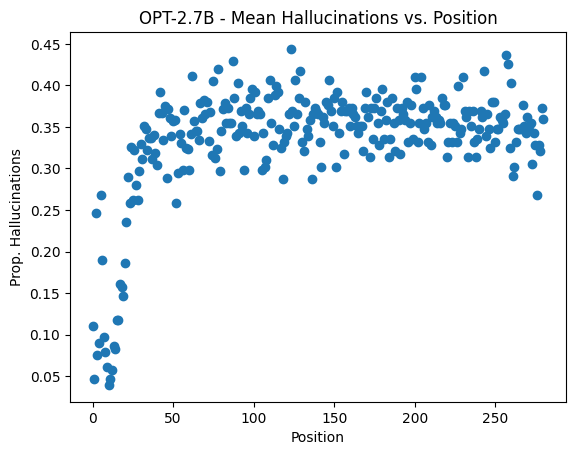

Doing pythia


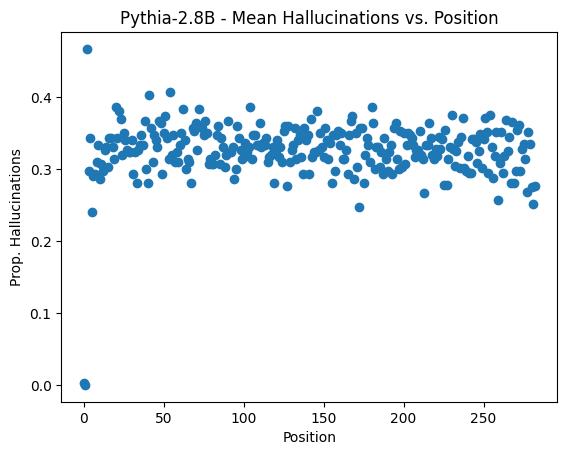

In [73]:
def pad_arrays(arrays):
    # Find the maximum length among the arrays
    max_len = max(arr.shape[0] for arr in arrays)
    
    # Pad each array with zeros at the end to match the maximum length
    padded_arrays = [np.pad(arr, (0, max_len - arr.shape[0]), 'constant') for arr in arrays]
    
    return padded_arrays

def avg_array(arrays):
    max_len = max(len(arr) for arr in arrays)
    sum_array = np.zeros(max_len)
    count_array = np.zeros(max_len)
    for arr in arrays:
        sum_array[:len(arr)] += arr
        count_array[:len(arr)] += 1
    return sum_array / count_array

for i, model in enumerate(MODELS):
    print(f"Doing {model}")
    all_labels = []
    for path in glob.glob(os.path.join(model, "*.pkl")):
        with open(path, "rb") as f:
            dat = pickle.load(f)
        all_labels.append(dat['labels'][-dat['top_k_probs'].shape[0]:])
    avgs = avg_array(all_labels)
    plt.scatter(np.arange(len(avgs)), avgs)
    title = f"{MODEL_NAMES[i]} - Mean Hallucinations vs. Position"
    plt.title(title)
    plt.xlabel("Position")
    plt.ylabel("Prop. Hallucinations")
    plt.savefig(os.path.join(FIG_OUT, f"{title}.pdf"), format="pdf", bbox_inches="tight")
    plt.show()

In [29]:
# Boring statistics

In [49]:
results = []
for model in MODELS:
    for winsize in [1, 5, 10, 15, 35, 50]:
        for stride in [1, winsize]:
            print(f"Doing {model}:{winsize}:{stride}")
            n_true = 0
            n_hallucinations = 0
            for path in glob.glob(os.path.join(model, "*.pkl")):
                with open(path, "rb") as f:
                    dat = pickle.load(f)
                try:
                    logits_windows, labels_windows = create_windows(dat, winsize, stride)
                except:
                    print(f"{path} is Fucked")
                    continue
                for logits, labels in zip(logits_windows, labels_windows):
                    if 1 in labels:
                        n_hallucinations += 1
                    else:
                        n_true += 1
            results.append(dict(model=model, winsize=winsize, stride=stride, hallucinations=n_hallucinations, truths=n_true, p_hallu=n_hallucinations/(n_hallucinations+n_true)))

Doing mini_GPT:1:1
Doing mini_GPT:1:1
Doing mini_GPT:5:1
Doing mini_GPT:5:5
Doing mini_GPT:10:1
Doing mini_GPT:10:10
Doing mini_GPT:15:1
Doing mini_GPT:15:15
Doing mini_GPT:35:1
Doing mini_GPT:35:35
Doing mini_GPT:50:1
Doing mini_GPT:50:50
Doing OPT:1:1
Doing OPT:1:1
Doing OPT:5:1
Doing OPT:5:5
Doing OPT:10:1
Doing OPT:10:10
Doing OPT:15:1
Doing OPT:15:15
Doing OPT:35:1
OPT\Stephen Miller (political advisor)_data.pkl is Fucked
Doing OPT:35:35
OPT\Stephen Miller (political advisor)_data.pkl is Fucked
Doing OPT:50:1
OPT\Radja Nainggolan_data.pkl is Fucked
OPT\Rii Sen_data.pkl is Fucked
OPT\Stephen Miller (political advisor)_data.pkl is Fucked
Doing OPT:50:50
OPT\Radja Nainggolan_data.pkl is Fucked
OPT\Rii Sen_data.pkl is Fucked
OPT\Stephen Miller (political advisor)_data.pkl is Fucked
Doing pythia:1:1
Doing pythia:1:1
Doing pythia:5:1
Doing pythia:5:5
Doing pythia:10:1
Doing pythia:10:10
Doing pythia:15:1
Doing pythia:15:15
Doing pythia:35:1
Doing pythia:35:35
Doing pythia:50:1
Doing pyt

In [50]:
df = pd.DataFrame(results)
df.to_csv("model_stats.csv")
all_stats = df

In [51]:
all_stats['total_windows'] = all_stats['hallucinations'] + all_stats['truths']
all_stats = all_stats.sort_values(["model", "winsize", "stride"]).reset_index().drop(columns=['index'])
all_stats.to_csv("model_stats.csv")
all_stats

,model,winsize,stride,hallucinations,truths,p_hallu,total_windows
0,OPT,1,1,25270,50545,0.333311,75815
1,OPT,1,1,25270,50545,0.333311,75815
2,OPT,5,1,53263,21432,0.713073,74695
3,OPT,5,5,10760,4380,0.710700,15140
4,OPT,10,1,58371,14924,0.796384,73295
5,OPT,10,10,5963,1605,0.787923,7568
6,OPT,15,1,60027,11868,0.834926,71895
7,OPT,15,15,3994,868,0.821473,4862
8,OPT,35,1,58613,7693,0.883977,66306
9,OPT,35,35,1904,255,0.881890,2159


In [52]:
all_stats = pd.read_csv("model_stats.csv").drop(columns=['Unnamed: 0'])
all_stats

,model,winsize,stride,hallucinations,truths,p_hallu,total_windows
0,OPT,1,1,25270,50545,0.333311,75815
1,OPT,1,1,25270,50545,0.333311,75815
2,OPT,5,1,53263,21432,0.713073,74695
3,OPT,5,5,10760,4380,0.710700,15140
4,OPT,10,1,58371,14924,0.796384,73295
5,OPT,10,10,5963,1605,0.787923,7568
6,OPT,15,1,60027,11868,0.834926,71895
7,OPT,15,15,3994,868,0.821473,4862
8,OPT,35,1,58613,7693,0.883977,66306
9,OPT,35,35,1904,255,0.881890,2159


In [339]:
# general data

In [53]:
for model in MODELS:
    n_gens = len(glob.glob(os.path.join(model, "*.pkl")))
    lens = []
    for path in glob.glob(os.path.join(model, "*.pkl")):
        with open(path, "rb") as f:
            dat = pickle.load(f)
        lens.append(len(dat['tokens']))
    print(f"Model: {model}. ngens: {n_gens}. mean len: {np.mean(lens)}")
    

Model: mini_GPT. ngens: 682. mean len: 253.74633431085044
Model: OPT. ngens: 280. mean len: 290.4428571428571
Model: pythia. ngens: 300. mean len: 299.7866666666667


In [1]:
# Quality check

In [54]:
all_hall_tokens = []
for path in glob.glob(os.path.join('mini_GPT', "*.pkl")):
    with open(path, "rb") as f:
        dat = pickle.load(f)
        hallucination_tokens = np.array(dat['tokens'])[dat['labels'] == 1]
        all_hall_tokens.extend(hallucination_tokens)

In [55]:
import pandas as pd
from collections import Counter

# Count occurrences of each word
word_counts = Counter(all_hall_tokens)

# Convert to a dataframe
df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])

df.sort_values("Count", ascending=False).head(15)

,Word,Count
28,his,563
200,and,194
187,He,187
671,her,175
98,known,158
226,with,146
359,0,142
80,1,129
225,career,122
72,201,121


In [199]:
for probs, labels in zip(size_7_wins[0], size_7_wins[1]):
    a = probs
    b = labels
    break

In [208]:
sp.stats.entropy(probs, axis = 1)

array([2.69150213e-02, 4.25586721e-07, 9.18427961e-05, 5.37581520e-04,
       5.39202321e-01, 7.59502051e-01, 7.09811391e-01])

In [149]:
for probs, labels in zip(size_7_wins[0], size_7_wins[1]):
    prop_lies.append(sum(labels)/len(labels))
    avg_ent.append(np.mean(sp.stats.entropy(probs, axis = 1)))
    #avg_max_prob.append(np.mean(np.max(dat['top_k_probs'].tolist(), axis=1)))
    #avg_fourth_prob.append(np.mean([i[-4].tolist()/i[-1] for i in dat['top_k_probs']]))

y = np.array(prop_lies)
x = np.array(avg_ent)
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create scatter plot
plt.scatter(x, y, label='Data')

# Plot the regression line
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')

# Display regression statistics
plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.2f}\nP-value: {p_value:.4f}\nStd Err: {std_err:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Add labels and legend
plt.xlabel('Avg Entropy')
plt.ylabel('Prop. Hallucinations')
plt.title(title)

plt.show()

torch.Size([191, 20])

In [153]:
len(dat['tokens'])

191

In [ ]:
tokenizer.decode(dat['tokens'][-dat['top_k_probs'].shape[0]:], skip_special_tokens = True)